# Machine Learning HW 4
## Ines Ajimi (ia2272)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

## Part 1: Build a classification model using text data

#### In part one of the homework, you will solve a text classification task. You can download the following data-sets from the HW data folder on the course website: HW4_Text_train_data.csv and HW4_text_test_data.csv. The data consists of Women’s fashion online shop reviews, consisting of a review text, and whether the review author would recommend the product. We are trying to determine whether a reviewer will recommend a product or not based on each review. In a real application this might allow us to find out what is good or bad about certain products or to feature more typical reviews (like a very critical and a very positive one).

#### Use cross-validation to evaluate the results. Use a metric that’s appropriate for imbalanced classification (AUC or average precision for example), and inspect all models by visualizing the coefficients.

#### To complete part one of the homework do the following: Import the text data, vectorize the review column into an X matrix.  Then run at least three models and select a single best model.  Note that you can also create three models that simply use different types of explanatory variables such as a logistic regression with different n grams or different tokenizers.  Be sure to explain your choice and evaluate this model using the test set.

First, I save the graphing function we used in the lecture notes.

In [2]:
# adding the helper function from lecture notes to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(0.05, 0.05 + 2 * n_top_features), #adjusted so ticks look nice for fewer n# top features
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")
    plt.show() #added so plot shows up

Then I import our data into the notebook as a pandas DataFrame, take a quick look at its contents, and convert our training data "Review" column into an array.

In [3]:
text_train = pd.read_csv("C:/Users/ia767/Downloads/HW4_Text_train_data.csv") #importing data
text_test = pd.read_csv("C:/Users/ia767/Downloads/HW4_Text_test_data.csv")

In [4]:
text_train.head(3)

,Review,Recommended
0,"""go to"" please offer a maxi for mature custome...",1
1,"""go to"" tee for sz 10+ women.Women who want so...",1
2,"""long and warm"".These leg warmers are perfect ...",1


In [5]:
text_test.head(3)

,Review,Recommended
0,"""beach business"".Great for the beachy business...",1
1,"""formal pajamas"".These are super comfy and so ...",1
2,"""perfect with jeans"".Great with leggings.perfe...",1


In [6]:
X_text_train = np.array(text_train["Review"]) #our X

I use CountVectorizer() to vectorize our text data.

In [7]:
vect = CountVectorizer().fit(X_text_train) #fit the count vectorizer
X = vect.transform(X_text_train) #transform our data

Next, I convert our y column into an array, and split our data into a training and test set.

In [8]:
y = np.array(text_train['Recommended']) #defining train y

In [9]:
# Set up training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 2)

Quick note: in addition to the usual "score" metric, I will be using a weighted **F1 score**, which takes into account both precision (limiting the number of false positives) and recall (limiting the number of false negatives). Both metrics are typically used for imbalanced data-sets because they take into account the initial number of observations into each class. The F-1 is the harmonic mean of precision and recall, and so should give a good overview of our model's performance.

### First Attempt with Log & Tree Models

The first model used is a simple **logistic** regression model, first unpenalized, then a penalized and tuned:

In [10]:
log = LogisticRegression().fit(X_train, y_train)
log_pred = log.predict(X_test)

print("Test set score: {:.2f}".format(log.score(X_test, y_test)))
print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(log, X_test, y_test, cv=10))) )
print("CV F1 Score: {:.2f}".format(np.mean(cross_val_score(log, X_test, y_test, cv=10, scoring = "f1_weighted"))) )

Test set score: 0.91
CV Test Score: 0.89
CV F1 Score: 0.89


In [9]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: ", grid.best_params_)
penal_log_reg = LogisticRegression(C = grid.best_params_["C"]).fit(X_train, y_train)
print("CV F1 Score: {:.2f}".format(np.mean(cross_val_score(penal_log_reg, X_test, y_test, cv=10, scoring = "f1_weighted"))) )

Best cross-validation score: 0.90
Test score: 0.91
Best parameters:  {'C': 0.1}
CV F1 Score: 0.89


The CV test score (on our training data) seems pretty high already, at over 89% for both models. The tuned, penalized model has a slightly higher CV test score, though the F1 scores are identical for both models.

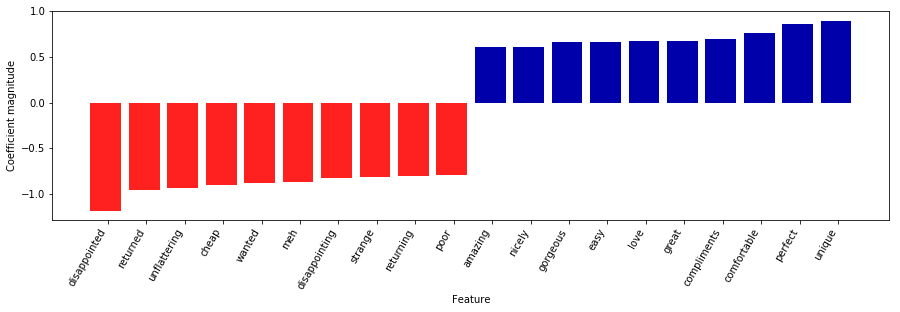

In [10]:
coefs = LogisticRegression(C = grid.best_params_["C"] ).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features= 10)

The graph above shows that the top predictors of 'negative' and 'positive' reviews are pretty much what we would expect ("disappointed" is a great indicator of a negative review, while "love" signals a positive review).

I try **Tree models** next:

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree_basic = DecisionTreeClassifier().fit(X_train, y_train)

print("Test set score: {:.3f}".format(tree_basic.score(X_test, y_test)))
print("CV Test Score: {:.2f}".format(np.mean(cross_val_score(tree_basic, X_test, y_test, cv=10))) )
print("CV F1 Score: {:.2f}".format(np.mean(cross_val_score(tree_basic, X_test, y_test, cv=10, scoring = "f1_weighted"))) )

Test set score: 0.815
CV Test Score: 0.81
CV F1 Score: 0.81


In [13]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
tree_bag = BaggingClassifier(tree, n_estimators=50, random_state=1).fit(X_train, y_train)

print("Test set score: {:.3f}".format(tree_bag.score(X_test, y_test)))
print("CV Test Score: {:.2f}".format(np.mean(cross_val_score(tree_bag, X_test, y_test, cv=10))) )
print("CV F1 Score: {:.2f}".format(np.mean(cross_val_score(tree_bag, X_test, y_test, cv=10, scoring = "f1_weighted"))) )

Test set score: 0.867
CV Test Score: 0.86
CV F1 Score: 0.84


The tree model doesn't fare as well as the basic log regression, even when using a Bagging Classifier to refine its predictions. The 5% difference in F1 score and the slowness of the Bagging Classifier are both significant cons of the model. 

The plot below shows the 10 most important features ranked by importance for the basic (non-Bagged) tree. 

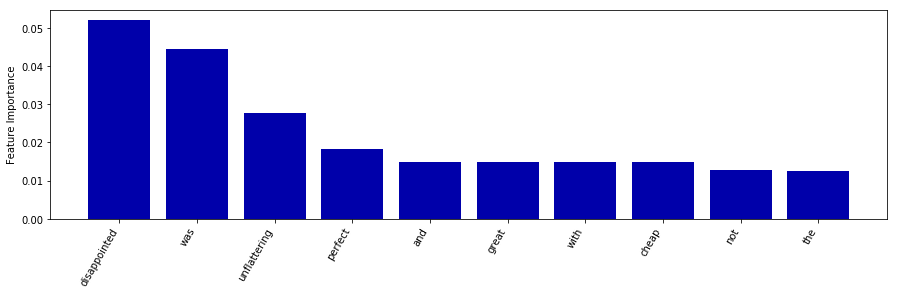

In [14]:
top_ten = np.argsort(-tree_basic.feature_importances_)[:10] #the index of the top 10 most important features
key_tree_coef = tree_basic.feature_importances_[top_ten] #the coefficients of the top 10 most important features 
names = [vect.get_feature_names()[np.argsort(-tree_basic.feature_importances_)[i]] for i in range(0,10)] 
#the feature names associated with the top 10 features

#the plot
plt.figure(figsize=(15, 5)) #size
plt.bar(np.arange(len(key_tree_coef)), key_tree_coef, color = '#0000aa')
plt.subplots_adjust(bottom=0.3)
plt.xticks(np.arange(0, len(key_tree_coef)), names, rotation=60,   ha="right")
plt.ylabel("Feature Importance")
plt.show() 

The plot helps understand why the tree models are underperfoming: un-informative words like "was", "with", & "and" are picked up as being some of the most relevant. The tree models may therefore benefit from some later alterations which filter out "stop words".

### Increasing Minimum Number of Occurences

In addition to using different models, I can tweak the way the words the model uses to train are selected. I first try to restrict the number of occurences that is required for a word to be included to the vocabulary to 10. I will only be using the logistic model from now on, given its superior performance on the initial dataset.

In [11]:
vect = CountVectorizer(min_df = 10, stop_words="english").fit(X_text_train)
X = vect.transform(X_text_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

I re-run the penalized log model, given that it had the best CV test score and a high F1 CV score, using this new X:

In [12]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))
print("CV F1 Score: {:.2f}".format(np.mean(cross_val_score(LogisticRegression(C = grid.best_params_["C"]).fit(X_train, y_train), X_test, y_test, cv=10, scoring = "f1_weighted"))) )

Best cross-validation score: 0.90
Test score: 0.90
CV F1 Score: 0.87


The CV test score and F1 scores both *decrease* slightly (-0.01, -0.02).

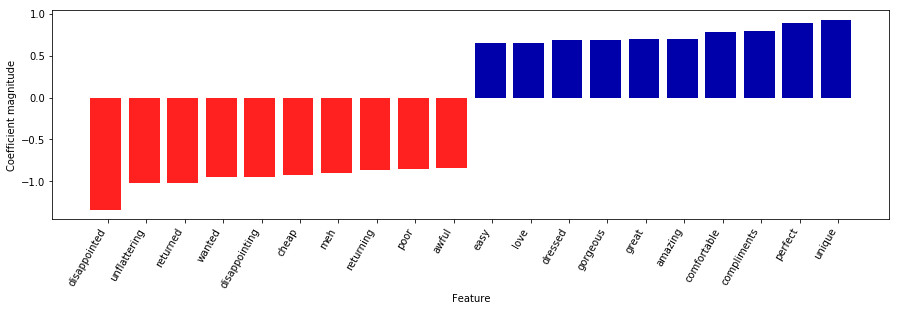

In [13]:
coefs = LogisticRegression(C = grid.best_params_["C"] ).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features= 10)

There doesn't seem to be much of a change in our features: "disappointed" it still the best predictor of a negative comment, much like "returned" and "unflattering. The most 'positive' words are also the same: "unique", "perfect", and "compliments".

### Removing Stop Words

I can also remove stop words, so the models will hopefully be able to focus on more informative features.

In [14]:
vect = CountVectorizer(min_df = 10, stop_words="english").fit(X_text_train)
X = vect.transform(X_text_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 2)

I re-run the penalized log models using this data:

In [15]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
log_restr = LogisticRegression(C = grid.best_params_["C"]).fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))
print("CV F1 Score: {:.2f}".format(np.mean(cross_val_score(log_restr, X_test, y_test, cv=10, scoring = "f1_weighted"))) )

Best cross-validation score: 0.90
Test score: 0.90
CV F1 Score: 0.87


Again, the test and F1 scores seem to have decreased by a negligeable amount.

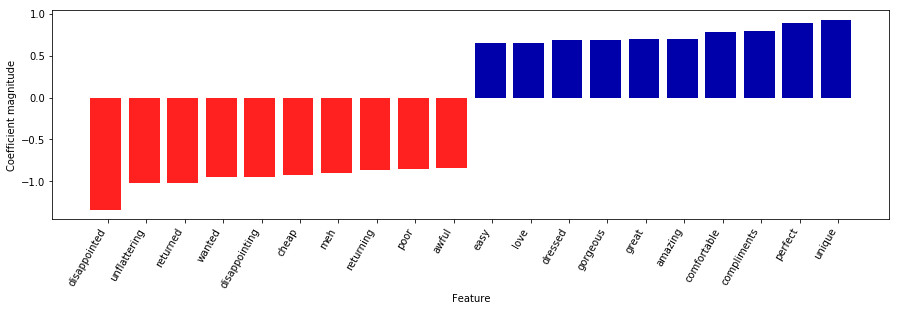

In [16]:
coefs = LogisticRegression(C = grid.best_params_["C"] ).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features= 10)

Moreover, the best predictors seem unchanged.

### Rescaling the Data with tf-idf

t-idf re-scales the data so that features that are over-represented in a given review will have larger weights. The model's predictions could then increase proportionally with the use of positive & negative predictors. However, the effectiveness of this approach in this instance is limited by the fact that people will not re-use the same features over & over again when writing.

In [17]:
vect = TfidfVectorizer(min_df = 10, norm = None).fit(X_text_train)
X = vect.transform(X_text_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

In [18]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
log_restr = LogisticRegression(C = grid.best_params_["C"]).fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))
print("CV F1 Score: {:.2f}".format(np.mean(cross_val_score(log_restr, X_test, y_test, cv=10, scoring = "f1_weighted"))) )

Best cross-validation score: 0.90
Test score: 0.91
CV F1 Score: 0.89


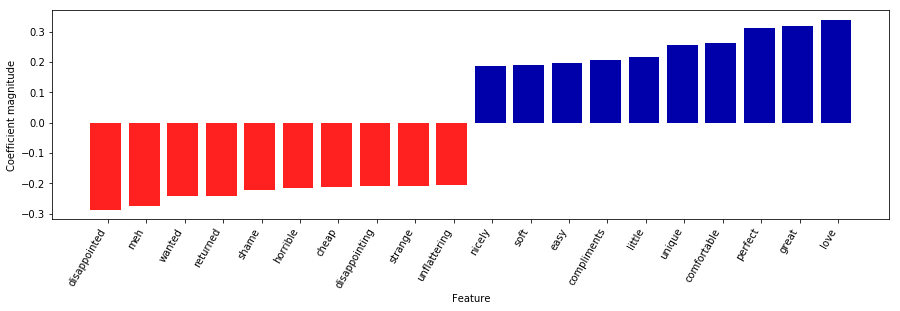

In [19]:
coefs = LogisticRegression(C = grid.best_params_["C"] ).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features= 10)

The F1 CV score is 89%, which is better than the previous tweaks that were attempted, but still not an improvement over the very first tuned, penalized model that I ran. The top features have a few new additions, namely "soft, "little" and "shame", but are otherwise unchanged.

### Testing The Model on The Test Dataset

The model I keep is the tuned penalized log linear regression, as it is both the best and fastest performing model I ran. I now measure its performance on the test dataset. I do not use any of the additional feature methods I tried previously, since they seemed to decrease the performance of my model.

In [20]:
X_true_test = vect.transform(np.array(text_test["Review"])) 
Y_true_test = np.array(text_test["Recommended"])

grid.fit(X_train, y_train)
log_restr = LogisticRegression(C = grid.best_params_["C"]).fit(X_train, y_train)


print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))
print("CV F1 Score: {:.2f}".format(np.mean(cross_val_score(log_restr, X_test, y_test, cv=10, scoring = "f1_weighted"))) )

Best cross-validation score: 0.90
Test score: 0.91
CV F1 Score: 0.89


The CV scores are almost as high as they were with our training data. The CV F1 score, in fact, is the same as we had for our first try! Overall, it seems the tuned, penalized log model's performance is fairly good.

## Part 2: Build a predictive neural network using Keras

#### To complete part two of the homework do the following: Run a multilayer perceptron (feed forward neural network) with two hidden layers on the iris dataset using the keras Sequential interface. Data can be imported via the following link: http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv

#### Include code for selecting the number of hidden units using GridSearchCV and evaluation on a test-set.  Describe the differences in the predictive accuracy of models with different numbers of hidden units.  Describe the predictive strength of your best model.  Be sure to explain your choice and evaluate this model using the test set.

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder

In [31]:
np.random.seed(10) #set random number seed for reproducibility

I start by importing the data, separating it into our predictor and predicted variables, and properly encoding the y values from strings to dummies.

In [32]:
data = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv" , encoding="latin_1")
data = data.iloc[:, 1:] #removes column that is just a row number
y = LabelEncoder().fit_transform(data['Species']) #selects and encodes y
X = data.loc[:, data.columns != 'Species'] #the rest, our x
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 2) # Set up training and test data

I take a quick look at the dataset:

In [33]:
data.head(3)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


I then create a function which generates feed-forward neural networks with two hidden layers. I use grid search to run through a range of neuron numbers for both layers.

In [38]:
def create_model(neurons1 = 12, neurons2 = 8): #model function
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim = X_train.shape[1], activation='relu'))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn = create_model, epochs=100, verbose=0)

param_grid = dict(neurons1 = range(1, 40, 8), neurons2 = range(1, 40, 8)) #grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid) 
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.651786 using {'neurons1': 9, 'neurons2': 9}


It seems that the model is optimized with 9 neurons in both layers.

I take a closer look at the change in test scores depending on the parameters used:

In [39]:
grid_result.cv_results_["mean_test_score"]

array([0.55357143, 0.44642857, 0.49107143, 0.64285714, 0.42857143,
       0.64285714, 0.65178571, 0.65178571, 0.65178571, 0.65178571,
       0.45535715, 0.65178571, 0.65178571, 0.65178571, 0.65178571,
       0.65178571, 0.65178571, 0.65178571, 0.65178571, 0.65178571,
       0.34821429, 0.64285714, 0.65178571, 0.65178571, 0.65178571])

In [40]:
grid_result.cv_results_["params"]

[{'neurons1': 1, 'neurons2': 1},
 {'neurons1': 1, 'neurons2': 9},
 {'neurons1': 1, 'neurons2': 17},
 {'neurons1': 1, 'neurons2': 25},
 {'neurons1': 1, 'neurons2': 33},
 {'neurons1': 9, 'neurons2': 1},
 {'neurons1': 9, 'neurons2': 9},
 {'neurons1': 9, 'neurons2': 17},
 {'neurons1': 9, 'neurons2': 25},
 {'neurons1': 9, 'neurons2': 33},
 {'neurons1': 17, 'neurons2': 1},
 {'neurons1': 17, 'neurons2': 9},
 {'neurons1': 17, 'neurons2': 17},
 {'neurons1': 17, 'neurons2': 25},
 {'neurons1': 17, 'neurons2': 33},
 {'neurons1': 25, 'neurons2': 1},
 {'neurons1': 25, 'neurons2': 9},
 {'neurons1': 25, 'neurons2': 17},
 {'neurons1': 25, 'neurons2': 25},
 {'neurons1': 25, 'neurons2': 33},
 {'neurons1': 33, 'neurons2': 1},
 {'neurons1': 33, 'neurons2': 9},
 {'neurons1': 33, 'neurons2': 17},
 {'neurons1': 33, 'neurons2': 25},
 {'neurons1': 33, 'neurons2': 33}]

The model performance plateaus after the 9, 9 neuron set-up. I will keep using the 9, 9 model, since its accuracy is among the highest *and* it is the 'leanest' model (best-performing model with the lowest number of neurons in each layer).

I then evaluate the model's performance on my test X and y.

In [43]:
model = Sequential()
model.add(Dense(grid.best_params_["neurons1"], input_dim = X_test.shape[1], activation='relu'))
model.add(Dense(grid.best_params_["neurons2"], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.evaluate(X_test, y_test, batch_size=128)

38/38 [==============================] - 5s 142ms/step


[0.11171633005142212, 0.28947368264198303]

Its performance is *not good*: accuracy is at 28.95%, which is just a bit better than a random guess. The model's accuracy could maybe be improved by tweaking its design (e.g. changing the number of layers) or trying out different activation methods.